In [2]:
# #实现几个函数来方便下载数据、
# 本节我们将通过Kaggle比赛，将所学知识付诸实践。
# Kaggle的房价预测比赛是一个很好的起点。 
# 此数据集由Bart de Cock于2011年收集 (De Cock, 2011)， 
# 涵盖了2006-2010年期间亚利桑那州埃姆斯市的房价。 
# 这个数据集是相当通用的，不会需要使用复杂模型架构。 
# 它比哈里森和鲁宾菲尔德的波士顿房价 数据集要大得多，也有更多的特征。

In [3]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [4]:
# download函数用来下载数据集
# 将数据集缓存在本地目录（默认情况下为../data）中， 并返回下载文件的名称
# 如果缓存目录中已经存在此数据集文件，并且其sha-1与存储在DATA_HUB中的相匹配， 
# 我们将使用缓存的文件，以避免重复的下载。
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [5]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [6]:
#数据分为训练数据和测试数据
#每条数据都记录包含房屋的属性值和属性
# 如街道类型、施工年份、屋顶类型、地下室状况等 这些特征由各种数据类型组成
#使用panda读入并处理数据
# 如果没有安装pandas，请取消下一行的注释
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [7]:
#用上面定义的脚本并缓存kaggle房屋数据集

DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [8]:
#pandas分别加载包含训练数据和测试数据的两个CSV文件。
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [9]:
print(train_data.shape)  #1460条 维度是81
print(test_data.shape) #1459条 维度是80

(1460, 81)
(1459, 80)


In [10]:
#查看前4个特征和最后两个特征 以及相应的房价标签
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [11]:
# 因为第一个特征是id 没有用故直接将其删掉
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [12]:
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [13]:
#将所有缺失值替换为相应特征的平均值 
# 通过将特征重新缩放到0均值和单位方差来标准化数据
# 若无法获得测试数据，则可根据训练数据计算均值和标准差


# 找到所有数值型特征的列名（数据类型不是 'object' 的列）
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

# 对所有数值型特征进行标准化处理
# 标准化是将数据调整为均值为0，标准差为1的形式
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())
)

# 在标准化数据之后，所有均值为0，因此我们可以将缺失值设置为0
# 这是因为在标准化过程中，缺失值会被忽略，而我们已经将均值调整为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)


In [14]:
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.067320,RL,-0.184443,-0.217841,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,0.157619,WD,Normal
1,-0.873466,RL,0.458096,-0.072032,Pave,NaN,Reg,Lvl,AllPub,FR2,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.446848,-0.602858,WD,Normal
2,0.067320,RL,-0.055935,0.137173,Pave,NaN,IR1,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,1.026577,0.157619,WD,Normal
3,0.302516,RL,-0.398622,-0.078371,Pave,NaN,IR1,Lvl,AllPub,Corner,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,-1.363335,WD,Abnorml
4,0.067320,RL,0.629439,0.518814,Pave,NaN,IR1,Lvl,AllPub,FR2,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,2.131647,0.157619,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,RM,-2.069222,-1.043758,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.078492,-1.363335,WD,Normal
1455,2.419286,RM,-2.069222,-1.049083,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.815205,-1.363335,WD,Abnorml
1456,-0.873466,RL,3.884968,1.246594,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,1.026577,-1.363335,WD,Abnorml
1457,0.655311,RL,-0.312950,0.034599,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,MnPrv,Shed,1.144116,0.289865,-1.363335,WD,Normal


In [15]:
#接下来处理字符串 离散值  用独热编码替换它们
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [16]:
#从panda格式中提取NumPy格式 并将其转换成张量表示
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [17]:
#训练
loss = nn.MSELoss()
# 获取特征数量
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

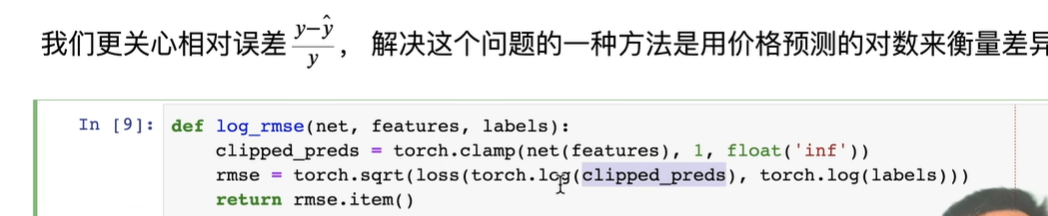

In [18]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    
    # 计算均方误差，并取对数
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    
    # 返回 RMSE 值（作为标量）
    return rmse.item()


In [19]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr=learning_rate,
                                 weight_decay=weight_decay)
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()  # 清空梯度
            l = loss(net(X), y)  # 计算损失
            l.backward()  # 反向传播
            optimizer.step()  # 更新参数
        
        # 记录训练集的对数均方根误差
        train_ls.append(log_rmse(net, train_features, train_labels))
        
        # 如果有测试集，记录测试集的对数均方根误差
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    
    return train_ls, test_ls

In [20]:
#K折交叉验证
def get_k_fold_data(k, i, X, y):
    assert k > 1  # 确保k大于1
    fold_size = X.shape[0] // k  # 每个折叠的大小

    X_train, y_train = None, None  # 初始化训练集特征和标签为空
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)  # 计算当前折叠的索引范围
        X_part, y_part = X[idx, :], y[idx]  # 获取当前折叠的数据部分
        if j == i:
            X_valid, y_valid = X_part, y_part  # 将第i个折叠作为验证集
        elif X_train is None:
            X_train, y_train = X_part, y_part  # 初始化训练集
        else:
            X_train = torch.cat([X_train, X_part], 0)  # 将数据部分拼接到训练集
            y_train = torch.cat([y_train, y_part], 0)  # 将标签部分拼接到训练集
    
    return X_train, y_train, X_valid, y_valid  # 返回训练集和验证集


In [21]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0  # 初始化训练误差和验证误差的累加值为0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)  # 获取第i折的训练和验证数据
        net = get_net()  # 获取一个新的网络实例
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)  # 训练模型并获取训练和验证误差
        train_l_sum += train_ls[-1]  # 将当前折的最后一个训练误差累加到总和
        valid_l_sum += valid_ls[-1]  # 将当前折的最后一个验证误差累加到总和
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')  # 画出第一个折的训练和验证误差曲线
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')  # 输出每一折的训练和验证误差
    return train_l_sum / k, valid_l_sum / k  # 返回所有折的平均训练误差和验证误差

折1，训练log rmse0.170515, 验证log rmse0.157101
折2，训练log rmse0.162341, 验证log rmse0.189941
折3，训练log rmse0.163854, 验证log rmse0.168406
折4，训练log rmse0.167751, 验证log rmse0.154384
折5，训练log rmse0.163213, 验证log rmse0.182732
5-折验证: 平均训练log rmse: 0.165535, 平均验证log rmse: 0.170513


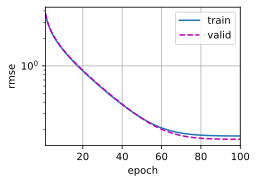

In [22]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [23]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()  # 获取一个新的网络实例
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)  # 训练模型并获取训练误差
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch', ylabel='log rmse', xlim=[1, num_epochs], yscale='log')  # 绘制训练误差曲线
    print(f'训练log rmse：{float(train_ls[-1]):f}')  # 输出最终的训练log rmse
    
    # 将网络应用于测试集，获取预测结果
    preds = net(test_features).detach().numpy()
    
    # 将预测结果重新格式化并添加到测试数据中
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    
    # 将测试数据的Id和预测的SalePrice合并成一个DataFrame
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    
    # 将结果保存到CSV文件中，以便提交到Kaggle
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.162496


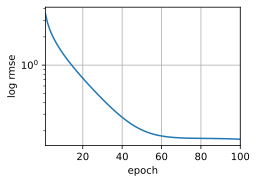

In [24]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)